In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_quad_no_constraint import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
# problem_spec['vector_size'] = 10
problem_spec['vector_size'] = 50
problem_spec['sc_theta'] = 1
problem_spec['sc_perturb'] = True
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()
problem_data['itr_num'] = 1000

{'n_node': 6, 'vector_size': 50, 'sc_theta': 1, 'sc_perturb': True}


In [3]:
Q = problem_data['Q']
b = problem_data['b']
n_node = problem_spec['n_node']
vector_size = problem_spec['vector_size']

for j in range(n_node):
    U, s, V = np.linalg.svd(Q[j])
    print([np.max(s), np.average(s), np.min(s)])

[0.5486775703114298, 0.1614201006834665, 1.7800854717859954e-06]
[0.6640265857673101, 0.1607519687361873, 5.0895862662606266e-05]
[0.6332673964293956, 0.16825257214924896, 0.000369813429890376]
[3.9935734394599556, 2.9421429353059376, 2.0559789396361237]
[3.9695024632852367, 3.0115478005488763, 2.0367287781909864]
[0.6592994331941643, 0.16798815433281247, 9.924808285031381e-06]


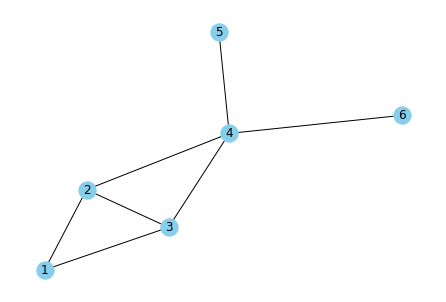

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
plt.savefig("plots/graph_n6.pdf")

In [5]:
f_star, x_opt_star = min_cvx_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.00019784422618054876, np.linalg.norm(x_opt_star)=0.007919692671855473


In [6]:
f_star, x_opt_star = min_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.0001978442261805488, np.linalg.norm(x_opt_star)=0.007919692671855473


In [7]:
Q = problem_data['Q']
b = problem_data['b']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
prox_operators = []
fi_operators = []

# Define functions and proximal operators to implement the method
for jj in range(n_node):
    Qj = Q[jj]
    bj = b[jj]
    # prox_operators += [lambda z, rho: cvx_prox_fj_quad_no_constraint(z, rho, problem_spec, problem_data, jj) ]
    prox_operators += [lambda z, rho, Qj=Qj, bj=bj, vector_size=vector_size : prox_fj_quad_no_constraint(z, rho, Qj, bj, vector_size) ]
    fi_operators += [lambda x_kj, Qj=Qj, bj=bj : 1/2 * x_kj @ Qj @ x_kj.T + np.dot(bj[0], x_kj) ]

    c = np.random.randn(vector_size)
    x1 = prox_operators[-1](c, 1/5)
    x2 = cvx_prox_fj_quad_no_constraint(c, 1/5, problem_spec, problem_data, jj, eps=1e-4)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

In [8]:
best_R = 1
find_best = True

# R = 18
start = 0.2
end = 4
space = 0.2
# end = 2
# space = 0.1

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        R = round(r, 2)
        # print("Testing R :", r)
        admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=False, freq=200)
        # new_val = sum(admm_f_reldiff[-10:]) / 10
        # new_val = sum(admm_f_reldiff[-300:]) / 300
        # new_val = sum(admm_f_reldiff[-300:-200]) / 100
        new_val = sum(admm_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_R :", round(r, 2),  ", new best_value :", new_val)
            best_value = new_val
            best_R = round(r, 2)

print("best_R :", best_R)

new best_R : 0.2 , new best_value : 1.3356050797106678e-13
new best_R : 0.4 , new best_value : 9.453137873382985e-17
best_R : 0.4


In [27]:
R = best_R
# R = 3.4
# R = 2
# R = 1
# R = 0.5
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        params={"R":R}, printing=True, freq=200)


ii=0, f_reldiff[-1]=1.356993141237165
ii=200, f_reldiff[-1]=1.3700199816497079e-16
ii=400, f_reldiff[-1]=1.3700199816497079e-16
ii=600, f_reldiff[-1]=1.3700199816497079e-16
ii=800, f_reldiff[-1]=1.3700199816497079e-16
ii=999, f_reldiff[-1]=0.0


In [10]:
# apply P-EXTRA 
best_rho = 1
find_best = True

# problem_data['rho'] = 0.01
# problem_data['rho'] = 0.1
# problem_data['rho'] = 0.2
# problem_data['rho'] = 0.5

start = 0.1
end = 4
space = 0.2

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        problem_data['rho'] = round(r, 2)
        # print("Testing rho :", r)
        pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_quad_no_constraint(problem_spec, problem_data, network_data, x_opt_star, f_star, printing=False, freq=200)
        # new_val = sum(pg_f_reldiff[-10:]) / 10
        # new_val = sum(pg_f_reldiff[-300:]) / 300
        # new_val = sum(pg_f_reldiff[-300:-200]) / 100
        new_val = sum(pg_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_rho :", round(r, 2),  "new best_value :", new_val)
            best_value = new_val
            best_rho = round(r, 2)

print("best_rho :",best_rho)

new best_rho : 0.1 new best_value : 1.5621291307557853e-08
new best_rho : 0.3 new best_value : 2.6966328653398007e-09
new best_rho : 0.5 new best_value : 4.174010669266156e-10
new best_rho : 0.7 new best_value : 1.4774232324189295e-10
best_rho : 0.7


In [11]:
problem_data['rho'] = best_rho
# problem_data['rho'] = 1
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_quad_no_constraint(problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

ii=0, f_reldiff[-1]=1.2546066103922984, err_opt_reldiff[-1]=0.4744382493134556
ii=200, f_reldiff[-1]=9.88621959580091e-07, err_opt_reldiff[-1]=5.94200772544027e-07
ii=400, f_reldiff[-1]=1.4986648579266155e-12, err_opt_reldiff[-1]=1.165756186600321e-12
ii=600, f_reldiff[-1]=6.850099908248539e-16, err_opt_reldiff[-1]=4.323303273344348e-15
ii=800, f_reldiff[-1]=6.850099908248539e-16, err_opt_reldiff[-1]=4.3795330196787094e-15
ii=999, f_reldiff[-1]=6.850099908248539e-16, err_opt_reldiff[-1]=4.380522698088852e-15


In [12]:
# params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
# params={"R":18, "Inductance":10, "Capacitance":1, "h":1.0541046971920436}
# params={"R":18, "Inductance":10, "h":1.1054814693822324}
# dadmm_c_all_err_opt_star, dadmm_c_all_err_opt_reldiff, dadmm_c_all_const_vio, dadmm_c_all_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
#                                                                                 network_data, x_opt_star, f_star, prox_operators=prox_operators,
#                                                                                 fi_operators=fi_operators,
#                                                                                 params=params, printing=True, sc_index_set={1,2,3,4,5,6}, freq=200)

In [49]:
# params={"R":0.5, "Inductance":4, "Capacitance":16, "h":2.764408907848405}
# params={"R":1, "Inductance":4, "Capacitance":8, "h":2.764408907848405}
# params={"R":1, "Inductance":4, "Capacitance":4, "h":1.382204453924203}

# params={"R":3, "Inductance":3, "Capacitance":8/3, "h":1.6540863202464} # worked good for R=3, N(0.5,1)
# params={"R":3, "Inductance":3, "Capacitance":8/3, "h":1.842939271898937} # worked good for R=3, N(0.5,1)



# params={"R":1, "Inductance":6, "Capacitance":8, "h":5.52881781569681} # worked good for Q[j] = Q[j]*50
# params={"R":1, "Inductance":6, "Capacitance":20, "h":5.52881781569681} # worked good for Q[j] = Q[j]*50

# params={"R":1, "Inductance":8, "Capacitance":8, "h":5.5409883749567} # worked good for Q[j] = Q[j]*50

# params={"R":0.5, "Inductance":11, "Capacitance":24, "h":10} # only test
# params={"R":1, "Inductance":6, "Capacitance":8, "h":5.13906193644284} # verified
# params={"R":2, "Inductance":3, "Capacitance":4, "h":2.321989931} # verified
# params={"R":3, "Inductance":3, "Capacitance":8/3, "h":1.6540863202464} # verified


# params={"R":4, "Inductance":2, "Capacitance":2, "h":1} # not verified, but worked well

# params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405} # verified


params={"R":0.5, "Inductance":11, "Capacitance":20, "h":10} # only test
# params={"R":2, "Inductance":3, "Capacitance":4, "h":3.4} # not verified, but worked well for [2.5,3.5]


# params={"R":1.5, "Inductance":4.5, "Capacitance":6, "h":4} # not verified, but worked well

# params={"R":2, "Inductance":3, "Capacitance":4, "h":2.764408907848405} # this also works
# params={"R":2, "Inductance":3, "Capacitance":3, "h":2.764408907848405} # this also works

# params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
# params={"R":18, "Inductance":10, "Capacitance":1, "h":1.0541046971920436}
# params={"R":18, "Inductance":10, "h":1.1054814693822324}


# params={"R":3, "Inductance":2, "Capacitance":8/3, "h":1.6540863202464} # fail

dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff  = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, sc_index_set={3,4}, freq=200)

ii=0, f_reldiff[-1]=1.8425631363353114
ii=200, f_reldiff[-1]=3.054529406406888e-08
ii=400, f_reldiff[-1]=9.270925215823574e-13
ii=600, f_reldiff[-1]=1.3700199816497079e-16
ii=800, f_reldiff[-1]=1.3700199816497079e-16
ii=999, f_reldiff[-1]=2.7400399632994157e-16


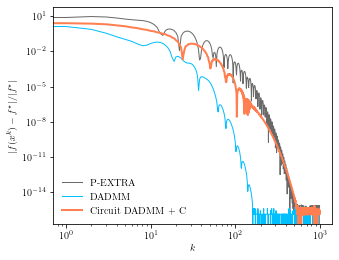

In [50]:
fname = "n6_qp_circuit_dadmm_c"

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' # default = 'dejavusans', other options = 'cm', 'stixsans', 'dejavuserif'
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'green'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA', color=black, linewidth=1)
plt.plot(admm_f_reldiff, label='DADMM', color=blue, linewidth=1)
# plt.plot(dadmm_c_all_f_reldiff, label='Circuit DADMM + C-All',  color=green, linewidth=1)
plt.plot(dadmm_c_f_reldiff, label='Circuit DADMM + C',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/|f^\star|$")
# plt.ylabel(r"$\|\tilde{\mathbf{A}}x_k\|^2_M$")
# plt.ylim(1e-15, 1e+2)
plt.autoscale(enable=True, axis='y', tight=None)
plt.legend()
plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)